In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

# -----------------------------
# 1. Load standardized matrix
# -----------------------------
# X_std: (num_samples, num_genes)
X_std = np.load("./data/archs4/processed_short_proteins/test_X_std_short.npy")
print("Loaded:", X_std.shape)
# -> e.g. (120000 samples, 19357 genes)

Xg = X_std.T.astype(np.float32)   # now shape = (num_genes, num_samples)
num_genes = Xg.shape[0]

print(f"Genes: {num_genes:,}, Samples: {Xg.shape[1]:,}")


Loaded: (9446, 19357)
Genes: 19,357, Samples: 9,446


In [6]:
use_gpu = True   # set False to use CPU

if use_gpu:
    device = "cuda"
    X_t = torch.tensor(Xg, device=device)

    # Normalize per gene (important!)
    X_t = (X_t - X_t.mean(dim=1, keepdim=True)) / X_t.std(dim=1, keepdim=True)

    torch.cuda.synchronize()
    t0 = time.time()

    # PCC = X Xᵀ / (n_samples - 1)
    pcc = torch.matmul(X_t, X_t.T) / (X_t.shape[1] - 1)
    pcc = torch.abs(pcc)

    torch.cuda.synchronize()
    print(f"GPU PCC computation took {time.time()-t0:.2f} sec")

    pcc_cpu = pcc.cpu().numpy()

else:
    device = "cpu"
    t0 = time.time()
    pcc_cpu = np.corrcoef(Xg)     # NumPy BLAS optimized
    pcc_cpu = np.abs(pcc_cpu)
    print(f"CPU PCC computation took {time.time()-t0:.1f} sec")


GPU PCC computation took 0.76 sec


In [7]:
threshold = 0.40
pcc_cpu[pcc_cpu < threshold] = 0.0


In [8]:
K = 20

# argpartition gives top-K indices very fast
topk_idx = np.argpartition(-pcc_cpu, K, axis=1)[:, :K]

rows = np.repeat(np.arange(num_genes), K)
cols = topk_idx.reshape(-1)

edge_index = torch.tensor(
    [rows, cols], dtype=torch.long
)

print("edge_index shape:", edge_index.shape)
# -> (2, num_genes*K)


edge_index shape: torch.Size([2, 387140])


/tmp/ipykernel_26008/557481098.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  edge_index = torch.tensor(


In [10]:
print(edge_index[:, :10])

tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [7178,    1,    2,    3,    4,    5,    6,    7,    8,    9]])


In [12]:
import os
os.makedirs("./graph", exist_ok=True)

np.save("./graph/adjacency_top20.npy", pcc_cpu)
torch.save(edge_index, "./graph/edge_index_top20.pt")


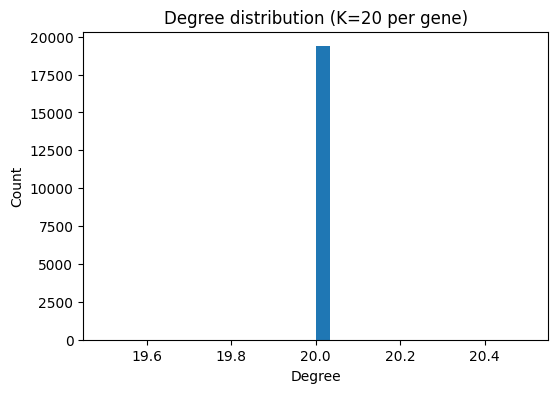

In [9]:
src = rows
unique, counts = np.unique(src, return_counts=True)

plt.figure(figsize=(6,4))
plt.hist(counts, bins=30)
plt.title("Degree distribution (K=20 per gene)")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()
